In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Query the Nordic Gridded Climate Dataset (NGCD) using Thredds and OPENDAP

The [Nordic Gridded Climate Dataset (NGCD)](https://thredds.met.no/thredds/catalog/ngcd/catalog.html) provides daily resolution precipitation and temperature data for Norway, Sweden and Finland at a spatial resolution of 1 km by 1 km.

The datasets are hosted on Thredds and, due to bandwidth limitations imposed by Met.no, querying data can be slow - **expect requests to take several hours**. If your locations of interest are all within Norway, consider using the [GTS API](https://nbviewer.org/github/NIVANorge/catchment_processing_workflows/blob/main/notebooks/nve_gts_api_example.ipynb) instead (see also the comparison of these datasets below).

## 1. Get time series for points (i.e. specific grid cells)

### 1.1. Example data

As a starting point, the user must supply a dataframe listing the locations of interest. The dataframe must include columns for the x and y co-ordinates, plus a column with a unique identifier for each location (in other words, each row of the dataframe should have a unique identifier).

Data can be provided in any co-ordinate system you wish, but if the co-ordinates are not WGS84-based lat/lon (the default), you **must remember to explicitly specify the CRS**. The data on Thredds requires co-ordinates in EPSG 3035, so whatever data you provide will first be reprojected to this CRS before submitting the query. This is handled automatically, *as long as you specify the original CRS correctly* (see below).

In [2]:
# Read example data from Finnmark
csv_path = "../example_data/quantom_catchment_outlets.csv"
df = pd.read_csv(csv_path, sep=";")

df.head()

,site_id,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,Njahkajavri,68.879606,23.761291,480
1,2,Vuomajeaggi,69.016558,24.142340,365
2,3,Juovvajohka,69.091233,24.473330,311
3,4,Caskin-jeaggi / Caskinjohka,68.926158,25.597493,211
4,6,Fáhttevárleakšá,69.594406,25.012381,350


### 1.2. Get time series

Specify your parameter and time period of interest and pass these to `nivapy.da.get_metno_ngcd_time_series()`, along with your dataframe of target locations. Available parameters are as follows:

 * `TG`: daily mean temperature (K)
 * `TN`: daily minimum temperature (K)
 * `TX`: daily maximum temperature (K)
 * `RR`: daily precipitation sum (mm)
 
Note that this function also takes two optional keyword arguments: `ngcd_version` and `ngcd_type`. These allow you to specify the exact version and spatial interpolation method for the NGCD product you wish to use (see [here](https://thredds.met.no/thredds/catalog/ngcd/catalog.html) for details). By default, NivaPy uses NGCD version 21.09 and "Type 2" (Bayesian spatial interpolation), which is the most up-to-date variant at the time of writing.

**Tip:** Because the download may take hours, **it's a good idea to explicitly save the result to CSV**. Issues with NIVA's VPN mean your browser may occasionally become "disconnected" from your Jupyter session, such that you no longer see results/output in your notebook cells even though the code is running fine (this is a more common issue with long-running workflows, where VPN changes are likely to occur). In addition, if you leave your code running and it finishes while you are not around, your server will shutdown automatically after an hour of inactivity. Explicitly saving your results means you can easily pick up where you left off.

**Tip 2:** The performance of Thredds varies a bit depending on how many other users are connected at the same time. You may therefore find your code finishes faster if you run it overnight or at the weekend.

In [3]:
par = "TG"
st_dt = "2010-01-01"
end_dt = "2020-12-31"

**Warning:** The cell below may take several hours to complete.

In [4]:
%%time

res_df = nivapy.da.get_metno_ngcd_time_series(
    df,
    par,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)

# Save result
res_df.to_csv(f"../example_data/ngcd_{par.lower()}_finnmark_points.csv", index=False)

Concatenating files from Thredds. This may take a while...
Extracting values for points. This may take a while...
CPU times: user 18min 47s, sys: 6min 58s, total: 25min 46s
Wall time: 1h 39min 39s


In [5]:
# Read saved data
res_df = pd.read_csv(
    f"../example_data/ngcd_{par.lower()}_finnmark_points.csv", parse_dates=["datetime"]
)
res_df.head()

,datetime,site_id,X,Y,lon,lat,TG
0,2010-01-01 06:00:00,1,4876500.0,5139500.0,23.764982,68.881140,258.15
1,2010-01-01 06:00:00,2,4888500.0,5157500.0,24.154163,69.018420,257.55
2,2010-01-01 06:00:00,3,4899500.0,5168500.0,24.483335,69.094980,257.45
3,2010-01-01 06:00:00,4,4947500.0,5160500.0,25.593230,68.930145,258.95
4,2010-01-01 06:00:00,6,4906500.0,5226500.0,25.000540,69.593124,256.05


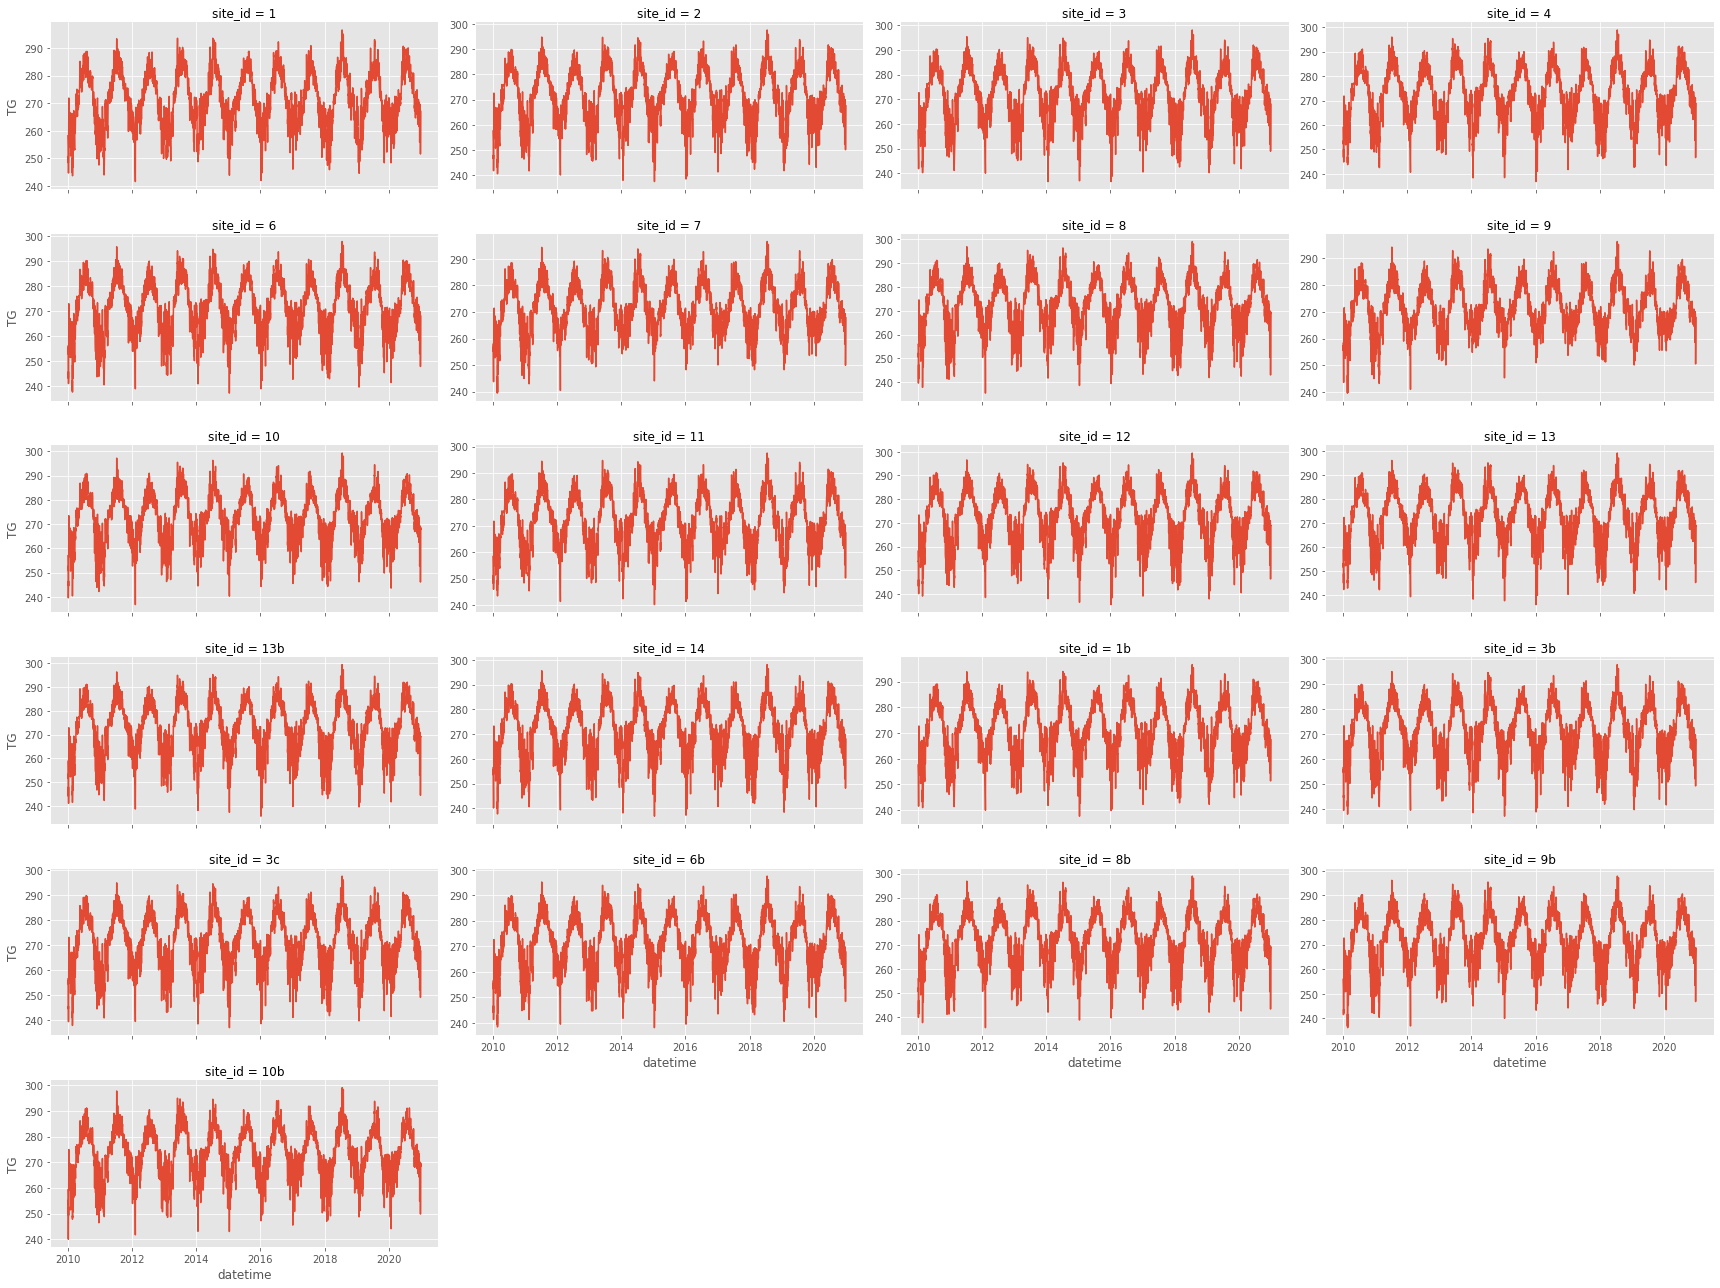

In [6]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y=par,
    col="site_id",
    col_wrap=4,
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)

### 1.3. Compare with results from NVE's GTS API

For sites in Norway, [getting data from the GTS API](https://nbviewer.org/github/NIVANorge/catchment_processing_workflows/blob/main/notebooks/nve_gts_api_example.ipynb) is much faster.

In [7]:
gts_pars = ["tm"]

gts_df = nivapy.da.get_nve_gts_api_time_series(
    df,
    gts_pars,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)
gts_df.head()

Looping over parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/21 [00:00<?, ?it/s]

,site_id,x_utm_33n,y_utm_33n,altitude_m,par,full_name,unit,time_resolution,datetime,value
0,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2010-01-01 06:00:00,-16.65
1,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2010-01-02 06:00:00,-18.55
2,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2010-01-03 06:00:00,-18.85
3,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2010-01-04 06:00:00,-20.65
4,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2010-01-05 06:00:00,-29.95


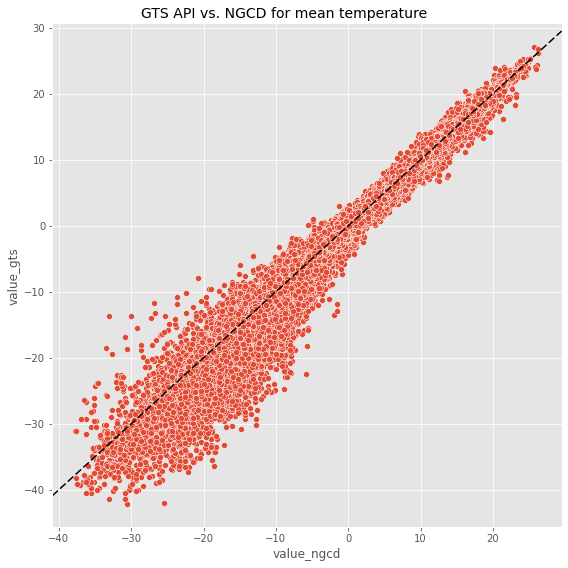

In [8]:
res_df.rename({"TG": "value"}, inplace=True, axis="columns")

# Convert K to C
res_df["value"] = res_df["value"] - 273.15

comp_df = pd.merge(
    res_df, gts_df, on=["datetime", "site_id"], how="inner", suffixes=["_ngcd", "_gts"]
)

g = sn.relplot(data=comp_df, x="value_ngcd", y="value_gts", height=8)
g.ax.axline(xy1=(0, 0), slope=1, color="k", dashes=(5, 2))
g.fig.suptitle("GTS API vs. NGCD for mean temperature", fontsize=14)
g.fig.subplots_adjust(top=0.95);

The plot above shows that results for mean daily temperature from the GTS API are similar to those from the NGCD. However, querying the GTS API for 21 sites in Finnmark for an 11 year period takes around 7 seconds, whereas getting similar data from NGCD via Thredds takes more than 1.5 hours.

## 2. Get time series for polygons (i.e. aggregate multiple grid cells)

### 2.1. Example data

The user must supply a geodataframe containing the polygons of interest. This could be read e.g. from a shapefile or from GeoJSON. Each row of the dataframe should represent one area of interest (use a [spatial dissolve](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) operation first if necessary) and there must be a column containing a unique identifier for each polygon.

The example here uses a geodataframe containing catchment boundaries for 21 small catchments in Finnmark.

In [9]:
# Example catchments in Finnmark
shp_path = r"../example_data/catchment_boundaries_2021.shp"
gdf = gpd.read_file(shp_path)
gdf.head()

,vassdragNr,areal_km2,site_name,site_id,geometry
0,234.GEB,9.40,Njahkajavri,1,"POLYGON ((850817.528 7669267.751, 851025.000 7..."
1,234.J3A0,84.26,Caskin-jeaggi / Caskinjohka,4,"POLYGON ((914016.660 7689380.680, 914222.460 7..."
2,234.GDAZ,41.24,Juovvajohka,3,"POLYGON ((870050.000 7694700.000, 870081.269 7..."
3,234.F3BZ,27.38,Gurrojohka,9,"POLYGON ((919269.498 7802100.122, 919364.457 7..."
4,234.GEA0,24.86,Vuomajeaggi,2,"POLYGON ((864315.450 7683072.205, 864387.977 7..."


### 2.2. Get aggregated time series

**Be sure that the CRS of the geodataframe is set correctly before querying Thredds**.

For each polygon-timestamp combination, the function returns the minimum, median, maximum, mean, standard deviation and count of grid cell values within the polygon. Note in particular that `value_count` is the number of 1 km x 1 km cell centres located within each polygon. The sum of values in a polygon can therefore be easily estimated as `count * mean`. The `count` column is also an approximate measure of the size of each polygon in square kilometres (i.e. the area when discretised into a 1 km grid).

**Warning:** The cell below may take several hours to complete.

In [10]:
%%time

par = "TG"
st_dt = "2010-01-01"
end_dt = "2020-12-31"

res_df = nivapy.da.get_metno_ngcd_aggregated_time_series(
    gdf,
    par,
    st_dt,
    end_dt,
    id_col="site_id",
)

# Save result
res_df.to_csv(f"../example_data/ngcd_{par.lower()}_finnmark_polys.csv", index=False)

Concatenating files from Thredds. This may take a while...
Extracting values for points. This may take a while...
CPU times: user 18min 46s, sys: 5min 26s, total: 24min 12s
Wall time: 1h 35min 21s


In [11]:
# Read saved data
res_df = pd.read_csv(
    f"../example_data/ngcd_{par.lower()}_finnmark_polys.csv", parse_dates=["datetime"]
)
res_df.head()

,site_id,datetime,TG_min,TG_median,TG_max,TG_mean,TG_std,TG_count
0,1,2010-01-01 06:00:00,258.050000,258.050000,258.150000,258.075000,0.046291,8
1,1,2010-01-02 06:00:00,256.250000,256.350001,256.449999,256.375000,0.070710,8
2,1,2010-01-03 06:00:00,255.350001,255.449999,255.449999,255.437499,0.035355,8
3,1,2010-01-04 06:00:00,254.150000,254.449999,254.750000,254.425000,0.198206,8
4,1,2010-01-05 06:00:00,248.050000,248.449999,248.750000,248.400000,0.256348,8


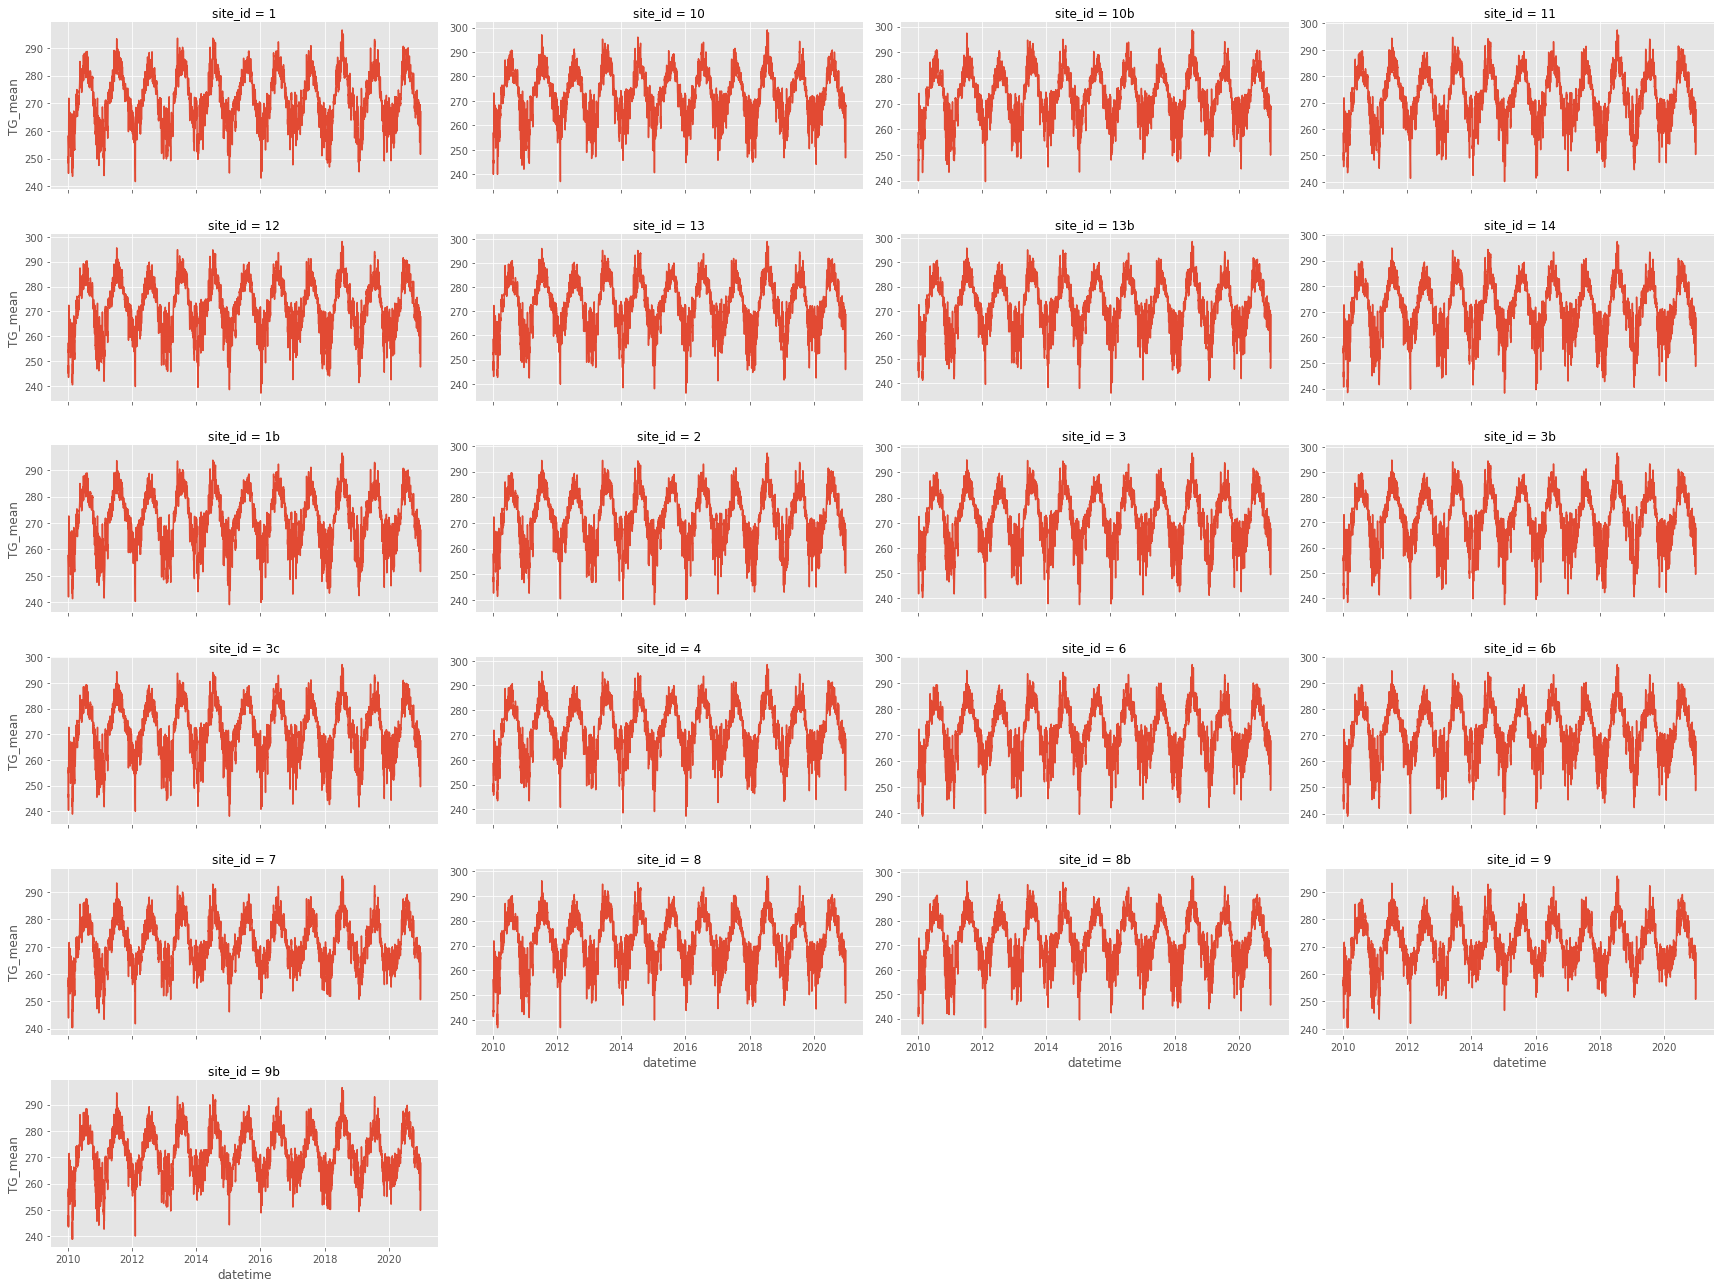

In [12]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y=f"{par}_mean",
    col="site_id",
    col_wrap=4,
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)